In [1]:
# Tang Kit Lim (WQD190032)

import datetime
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import distance
from pathlib import Path

In [2]:
# load data from csv

data_directory = '../data/processed/'
Path(data_directory).mkdir(parents=True, exist_ok=True)

preprocessed_township_csv = data_directory + 'edgeprop_townships_preprocessed.csv'
preprocessed_transaction_csv = data_directory + 'edgeprop_transactions_preprocessed.csv'
preprocessed_poi_csv = data_directory + 'iproperty_pois_preprocessed.csv'

transaction_csv = data_directory + 'edgeprop_transactions_processed.csv'

townships = pd.read_csv(preprocessed_township_csv, na_values=['None'], index_col=0)
transactions = pd.read_csv(preprocessed_transaction_csv, na_values=['None'], index_col=0)
pois = pd.read_csv(preprocessed_poi_csv, na_values=['None'], index_col=0)


## Merge Township dataset into Transaction dataset


In [3]:
# Merge using inner join, transactions without township information will be ignored

transactions = transactions.merge(townships, left_on='project_id', right_on='project_id', suffixes=('', '_township'))

## Data Cleaning


In [4]:
transactions

,project_id,project_name,transacted_price,unit_price_psf,date,property_type,tenure,floor,area_sqft,non_landed,...,median_price,poi_nearby_education,poi_nearby_transportation,poi_nearby_healthcare,nearest_school,nearest_train_station,nearest_hospital,total_poi_nearby,nearest_poi,transaction_count
0,15667,"Taman Sinaran, Cheras",98000,152.0,1498176000,Flat,Freehold,1,646.0,1,...,192500.0,8,1,4,1592.071688,2852.547546,2693.332317,13,1592.071688,28
1,15667,"Taman Sinaran, Cheras",205000,244.0,1492560000,Condominium/Apartment,Freehold,1,840.0,1,...,192500.0,8,1,4,1592.071688,2852.547546,2693.332317,13,1592.071688,28
2,15667,"Taman Sinaran, Cheras",98000,152.0,1491782400,Flat,Freehold,1,646.0,1,...,192500.0,8,1,4,1592.071688,2852.547546,2693.332317,13,1592.071688,28
3,15667,"Taman Sinaran, Cheras",98000,152.0,1491782400,Flat,Freehold,2,646.0,1,...,192500.0,8,1,4,1592.071688,2852.547546,2693.332317,13,1592.071688,28
4,15667,"Taman Sinaran, Cheras",155000,209.0,1487030400,Flat,Freehold,4,743.0,1,...,192500.0,8,1,4,1592.071688,2852.547546,2693.332317,13,1592.071688,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204278,27987,Woodsbury Suites,430000,470.0,1532995200,Condominium/Apartment,Freehold,9,915.0,1,...,362000.0,22,2,2,214.605874,2131.491981,1755.799610,26,214.605874,16
204279,27987,Woodsbury Suites,370000,491.0,1532908800,Condominium/Apartment,Freehold,24,753.0,1,...,362000.0,22,2,2,214.605874,2131.491981,1755.799610,26,214.605874,16
204280,27987,Woodsbury Suites,355000,471.0,1521676800,Condominium/Apartment,Freehold,25,753.0,1,...,362000.0,22,2,2,214.605874,2131.491981,1755.799610,26,214.605874,16
204281,27987,Woodsbury Suites,369000,490.0,1519603200,Condominium/Apartment,Freehold,22,753.0,1,...,362000.0,22,2,2,214.605874,2131.491981,1755.799610,26,214.605874,16


In [5]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204283 entries, 0 to 204282
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   project_id                 204283 non-null  int64  
 1   project_name               204283 non-null  object 
 2   transacted_price           204283 non-null  int64  
 3   unit_price_psf             204253 non-null  float64
 4   date                       204283 non-null  int64  
 5   property_type              204283 non-null  object 
 6   tenure                     204283 non-null  object 
 7   floor                      84613 non-null   object 
 8   area_sqft                  204283 non-null  float64
 9   non_landed                 204283 non-null  int64  
 10  bedrooms                   204283 non-null  float64
 11  psf                        204283 non-null  float64
 12  price                      204283 non-null  int64  
 13  state                      20

In [6]:
# check similar features
# transactions[(transactions['unit_price_psf'] != transactions['psf'])][['unit_price_psf', 'psf']].describe()
# 'unit_price_psf' and 'psf' are identical before recalculation during data preparation, keep 'psf' only

In [7]:
# check similar features
transactions[(transactions['transacted_price'] != transactions['price'])][['transacted_price', 'price']].describe()
# 'transacted_price' and 'price' are identical, keep one

,transacted_price,price
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


In [8]:
# check similar features
transactions[(transactions['state'] != transactions['state_township'])][[
    'state', 'state_township', 'project_id', 'latitude', 'longitude'
]]
# state and state_township are almost identical, with few exceptions. 
# state_township is more accurate based on the gps location, keep state_township (rename to state)

,state,state_township,project_id,latitude,longitude
11809,Kuala Lumpur,Selangor,12192,3.081360,101.762001
11997,Kuala Lumpur,Penang,12374,5.356920,100.429001
19307,Kuala Lumpur,Perak,12752,4.598970,101.056000
62289,Selangor,Johor,13183,1.571710,103.611000
76475,Johor,Penang,17337,5.269977,100.471551
76476,Johor,Penang,17337,5.269977,100.471551
76477,Johor,Penang,17337,5.269977,100.471551
76478,Johor,Penang,17337,5.269977,100.471551
76479,Johor,Penang,17337,5.269977,100.471551
76480,Johor,Penang,17337,5.269977,100.471551


## Handling Incorrect Data

In [9]:
# remove all transactions with gps coordination out of Malaysia
transactions = transactions[~(
    (transactions['latitude'] < 0.85) |
    (transactions['latitude'] > 7.4) |
    (transactions['longitude'] < 99.5) | 
    (transactions['longitude'] > 119.3) | 
    (pd.isna(transactions['latitude'])) |
    (pd.isna(transactions['longitude'])) 
)]


In [10]:
# area (location of the transaction) & area_sqft (actualy area of the transaction in sqft) 
# could be confusing. Going to rename area as city.
transactions['area'].value_counts()

Johor Bahru       9100
Shah Alam         7988
Klang             6174
Puchong           5061
Kajang            4963
                  ... 
Ledang Heights       3
East Ledang          2
Paloh                2
Gemas                1
Ipoh                 1
Name: area, Length: 273, dtype: int64

In [11]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191411 entries, 0 to 204282
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   project_id                 191411 non-null  int64  
 1   project_name               191411 non-null  object 
 2   transacted_price           191411 non-null  int64  
 3   unit_price_psf             191388 non-null  float64
 4   date                       191411 non-null  int64  
 5   property_type              191411 non-null  object 
 6   tenure                     191411 non-null  object 
 7   floor                      82564 non-null   object 
 8   area_sqft                  191411 non-null  float64
 9   non_landed                 191411 non-null  int64  
 10  bedrooms                   191411 non-null  float64
 11  psf                        191411 non-null  float64
 12  price                      191411 non-null  int64  
 13  state                      19

In [12]:
transactions[transactions['area_sqft'] == 0]['area_sqft'].value_counts()

Series([], Name: area_sqft, dtype: int64)

In [13]:
# 0 area_sqft will cause problems to psf calculation (inf)
# drop observation with 0 area_sqft

transactions = transactions[~(transactions['area_sqft'] == 0)]
transactions['area_sqft'].min()

11.0

In [14]:
# extract year from epoch and store as new column
import time
transactions['year'] = transactions['date'].apply(
    lambda x: str(pd.Timestamp(x, unit='s')).split("-")[0]
)

In [15]:
# drop rows without values for 'psf', 'median_psf'
# drop feature 'floor', too little observation 
# drop columns which are not useful for the current model: project_id, date, psf, latitude, longitude, median_price
# drop redundant features 'transacted_price', 'unit_price_psf', 'state'
# rename 'state_township' as 'state'
# 'median_psf', 'median_price', 'psf' will cause overfitting, 
# but it's usefull to detect outliers, keep for now, drop later.

transactions_bk = transactions.copy()
transactions.dropna(subset = ['psf'], how = 'any', inplace = True)
transactions.drop(columns=[
    'floor', 'transacted_price', 'unit_price_psf', 'state', 'date', 'latitude', 'longitude'
], inplace = True)
transactions.rename(columns={'state_township': 'state', 'project_name': 'township', 'area': 'city'}, inplace = True)

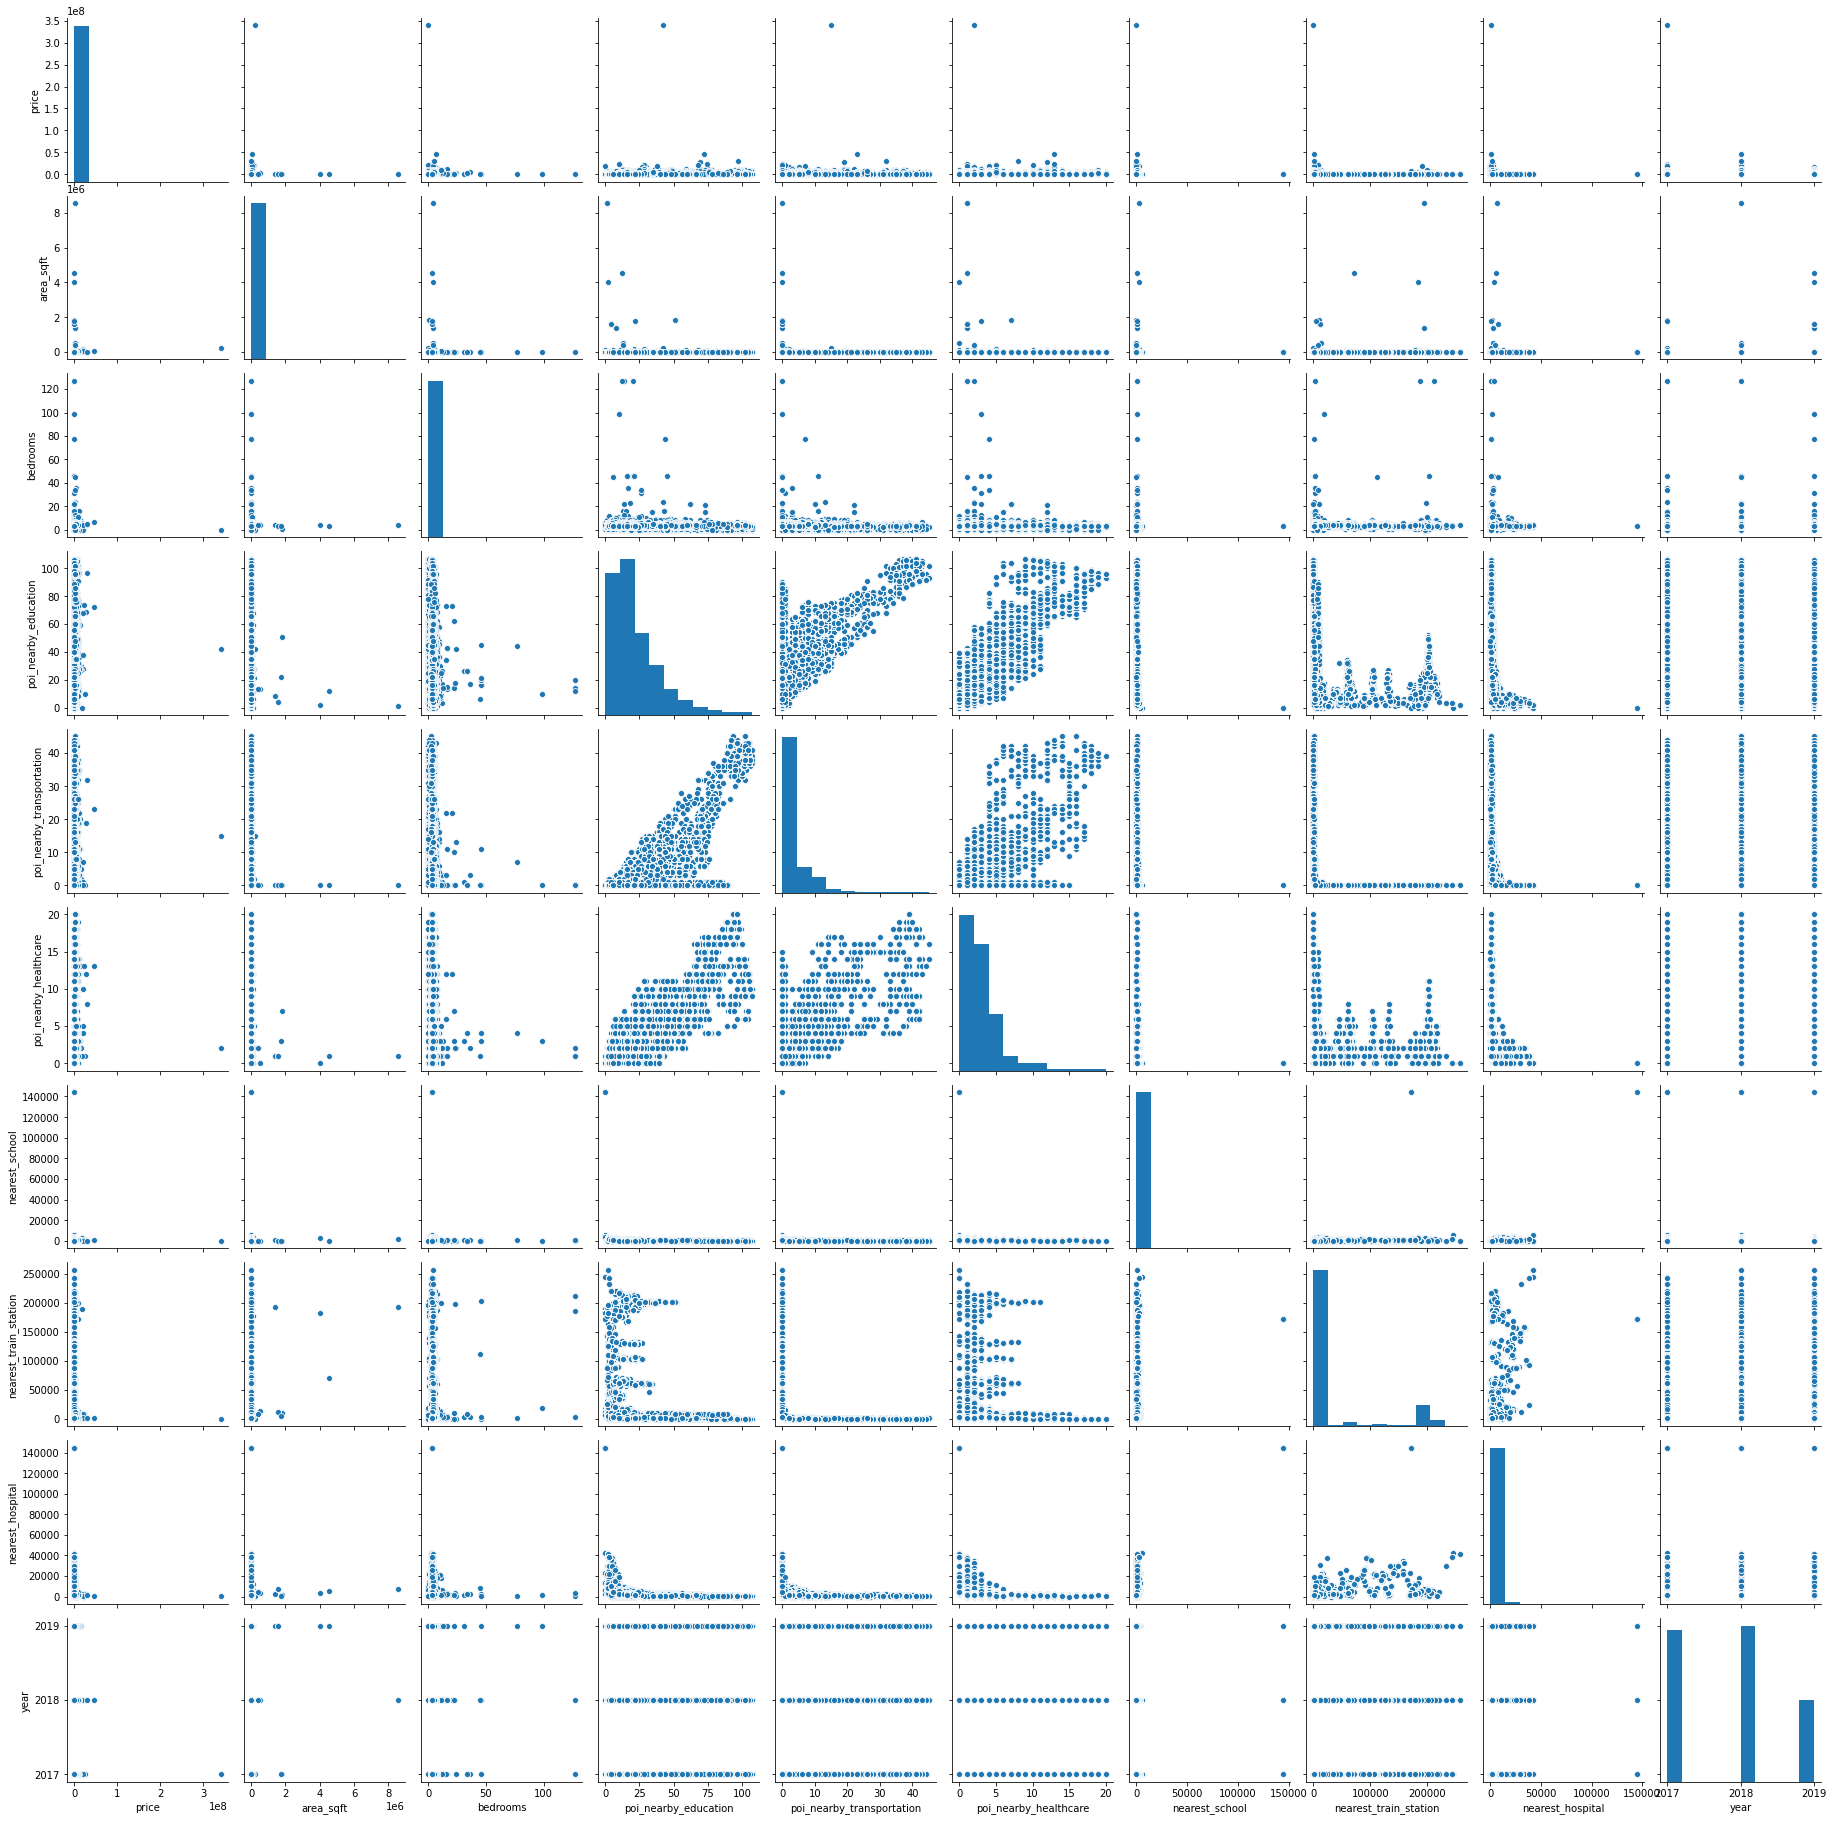

In [16]:
import matplotlib
import seaborn as sns
# sns.pairplot(transactions[['price', 'area_sqft', 'bedrooms', 'total_poi_nearby', 'nearest_poi']])
sns.pairplot(transactions[[
    'price', 'area_sqft', 'bedrooms', 'poi_nearby_education','poi_nearby_transportation','poi_nearby_healthcare', 
    'nearest_school', 'nearest_train_station', 'nearest_hospital', 'year'
]])

# Remove outliers

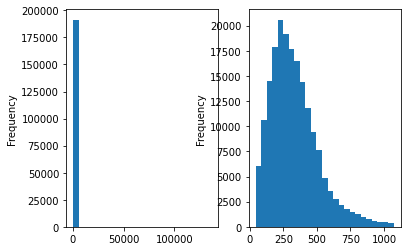

In [17]:

fig, axes = plt.subplots(1, 2)

transactions['psf'].plot.hist('Before', bins=25, ax=axes[0])

# transactions['psf'] = transactions['price']/transactions['area_sqft']
min_psf, max_psf = transactions['psf'].quantile([0.01, 0.99])

# drop if they are outliers
transactions = transactions[
    (transactions['psf'] > min_psf) &
    (transactions['psf'] < max_psf)
]
transactions['psf'].plot.hist('After', bins=25, ax=axes[1])



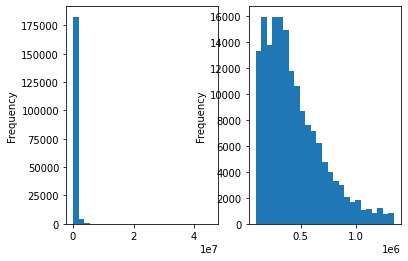

In [18]:
fig, axes = plt.subplots(1, 2)

transactions['price'].plot.hist('Before', bins=25, ax=axes[0])

min_price, max_price = transactions['price'].quantile([0.05, 0.95])

# drop if they are outliers
transactions = transactions[
    (transactions['price'] > min_price) &
    (transactions['price'] < max_price)
]

transactions['price'].plot.hist('After', bins=25, ax=axes[1])



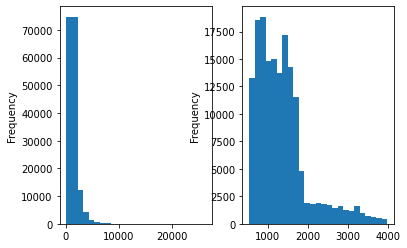

In [19]:
fig, axes = plt.subplots(1, 2)

transactions['area_sqft'].plot.hist('Before', bins=25, ax=axes[0])

min_area, max_area = transactions['area_sqft'].quantile([0.02, 0.98])

# drop if they are outliers
transactions = transactions[
    (transactions['area_sqft'] > min_area) &
    (transactions['area_sqft'] < max_area)
]

transactions['area_sqft'].plot.hist('After', bins=25, ax=axes[1])

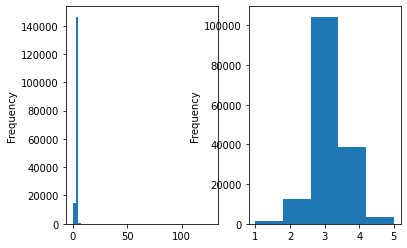

In [20]:
fig, axes = plt.subplots(1, 2)

transactions['bedrooms'].plot.hist('Before', bins=50, ax=axes[0])

min_bedroom, max_bedroom = transactions['bedrooms'].astype(int).quantile([0.00, 0.999])

# drop if they are outliers
transactions = transactions[
    (transactions['bedrooms'] > min_bedroom) &
    (transactions['bedrooms'] < max_bedroom)
]

transactions['bedrooms'].plot.hist('After', bins=5, ax=axes[1])

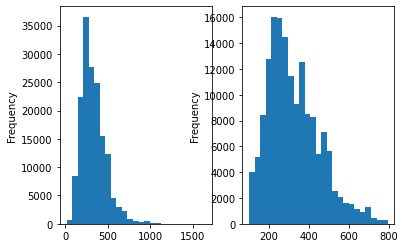

In [21]:
fig, axes = plt.subplots(1, 2)

transactions['median_psf'].plot.hist('Before', bins=25, ax=axes[0])

min_median_psf, max_median_psf = transactions['median_psf'].astype(int).quantile([0.01, 0.99])

# drop if they are outliers
transactions = transactions[
    (transactions['median_psf'] > min_median_psf) &
    (transactions['median_psf'] < max_median_psf)
]

transactions['median_psf'].plot.hist('After', bins=25, ax=axes[1])

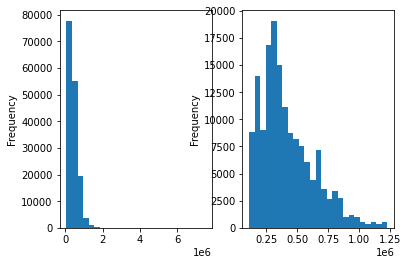

In [22]:
fig, axes = plt.subplots(1, 2)

transactions['median_price'].plot.hist('Before', bins=25, ax=axes[0])

min_median_price, max_median_price = transactions['median_price'].astype(int).quantile([0.01, 0.99])

# drop if they are outliers
transactions = transactions[
    (transactions['median_price'] > min_median_price) &
    (transactions['median_price'] < max_median_price)
]

transactions['median_price'].plot.hist('After', bins=25, ax=axes[1])

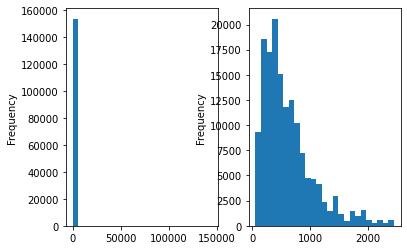

In [23]:
fig, axes = plt.subplots(1, 2)

transactions['nearest_poi'].plot.hist('Before', bins=25, ax=axes[0])

min_nearest_poi, max_nearest_poi = transactions['nearest_poi'].astype(int).quantile([0.01, 0.99])

# drop if they are outliers
transactions = transactions[
    (transactions['nearest_poi'] > min_nearest_poi) &
    (transactions['nearest_poi'] < max_nearest_poi)
]

transactions['nearest_poi'].plot.hist('After', bins=25, ax=axes[1])

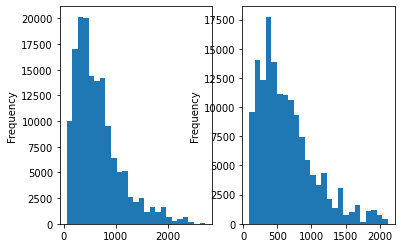

In [24]:
fig, axes = plt.subplots(1, 2)

transactions['nearest_school'].plot.hist('Before', bins=25, ax=axes[0])

min_nearest_poi, max_nearest_poi = transactions['nearest_school'].astype(int).quantile([0.01, 0.99])

# drop if they are outliers
transactions = transactions[
    (transactions['nearest_school'] > min_nearest_poi) &
    (transactions['nearest_school'] < max_nearest_poi)
]

transactions['nearest_school'].plot.hist('After', bins=25, ax=axes[1])

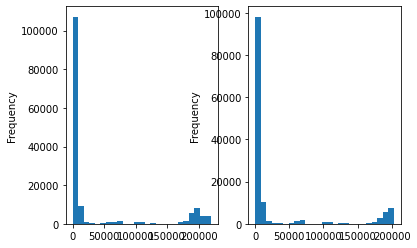

In [25]:
fig, axes = plt.subplots(1, 2)

transactions['nearest_train_station'].plot.hist('Before', bins=25, ax=axes[0])

min_nearest_poi, max_nearest_poi = transactions['nearest_train_station'].astype(int).quantile([0.05, 0.95])

# drop if they are outliers
transactions = transactions[
    (transactions['nearest_train_station'] > min_nearest_poi) &
    (transactions['nearest_train_station'] < max_nearest_poi)
]

transactions['nearest_train_station'].plot.hist('After', bins=25, ax=axes[1])

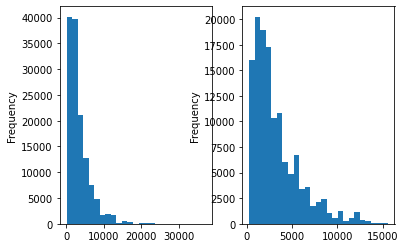

In [26]:
fig, axes = plt.subplots(1, 2)

transactions['nearest_hospital'].plot.hist('Before', bins=25, ax=axes[0])

min_nearest_poi, max_nearest_poi = transactions['nearest_hospital'].astype(int).quantile([0.01, 0.99])

# drop if they are outliers
transactions = transactions[
    (transactions['nearest_hospital'] > min_nearest_poi) &
    (transactions['nearest_hospital'] < max_nearest_poi)
]

transactions['nearest_hospital'].plot.hist('After', bins=25, ax=axes[1])

In [27]:
transactions['property_type'].value_counts()

Terrace House              62556
Condominium/Apartment      34001
Flat                       19235
Semi-Detached House         5092
Hotel/Service Apartment     3715
Cluster House               2013
Town House                  1698
Low-Cost House              1391
Detached House               612
Name: property_type, dtype: int64

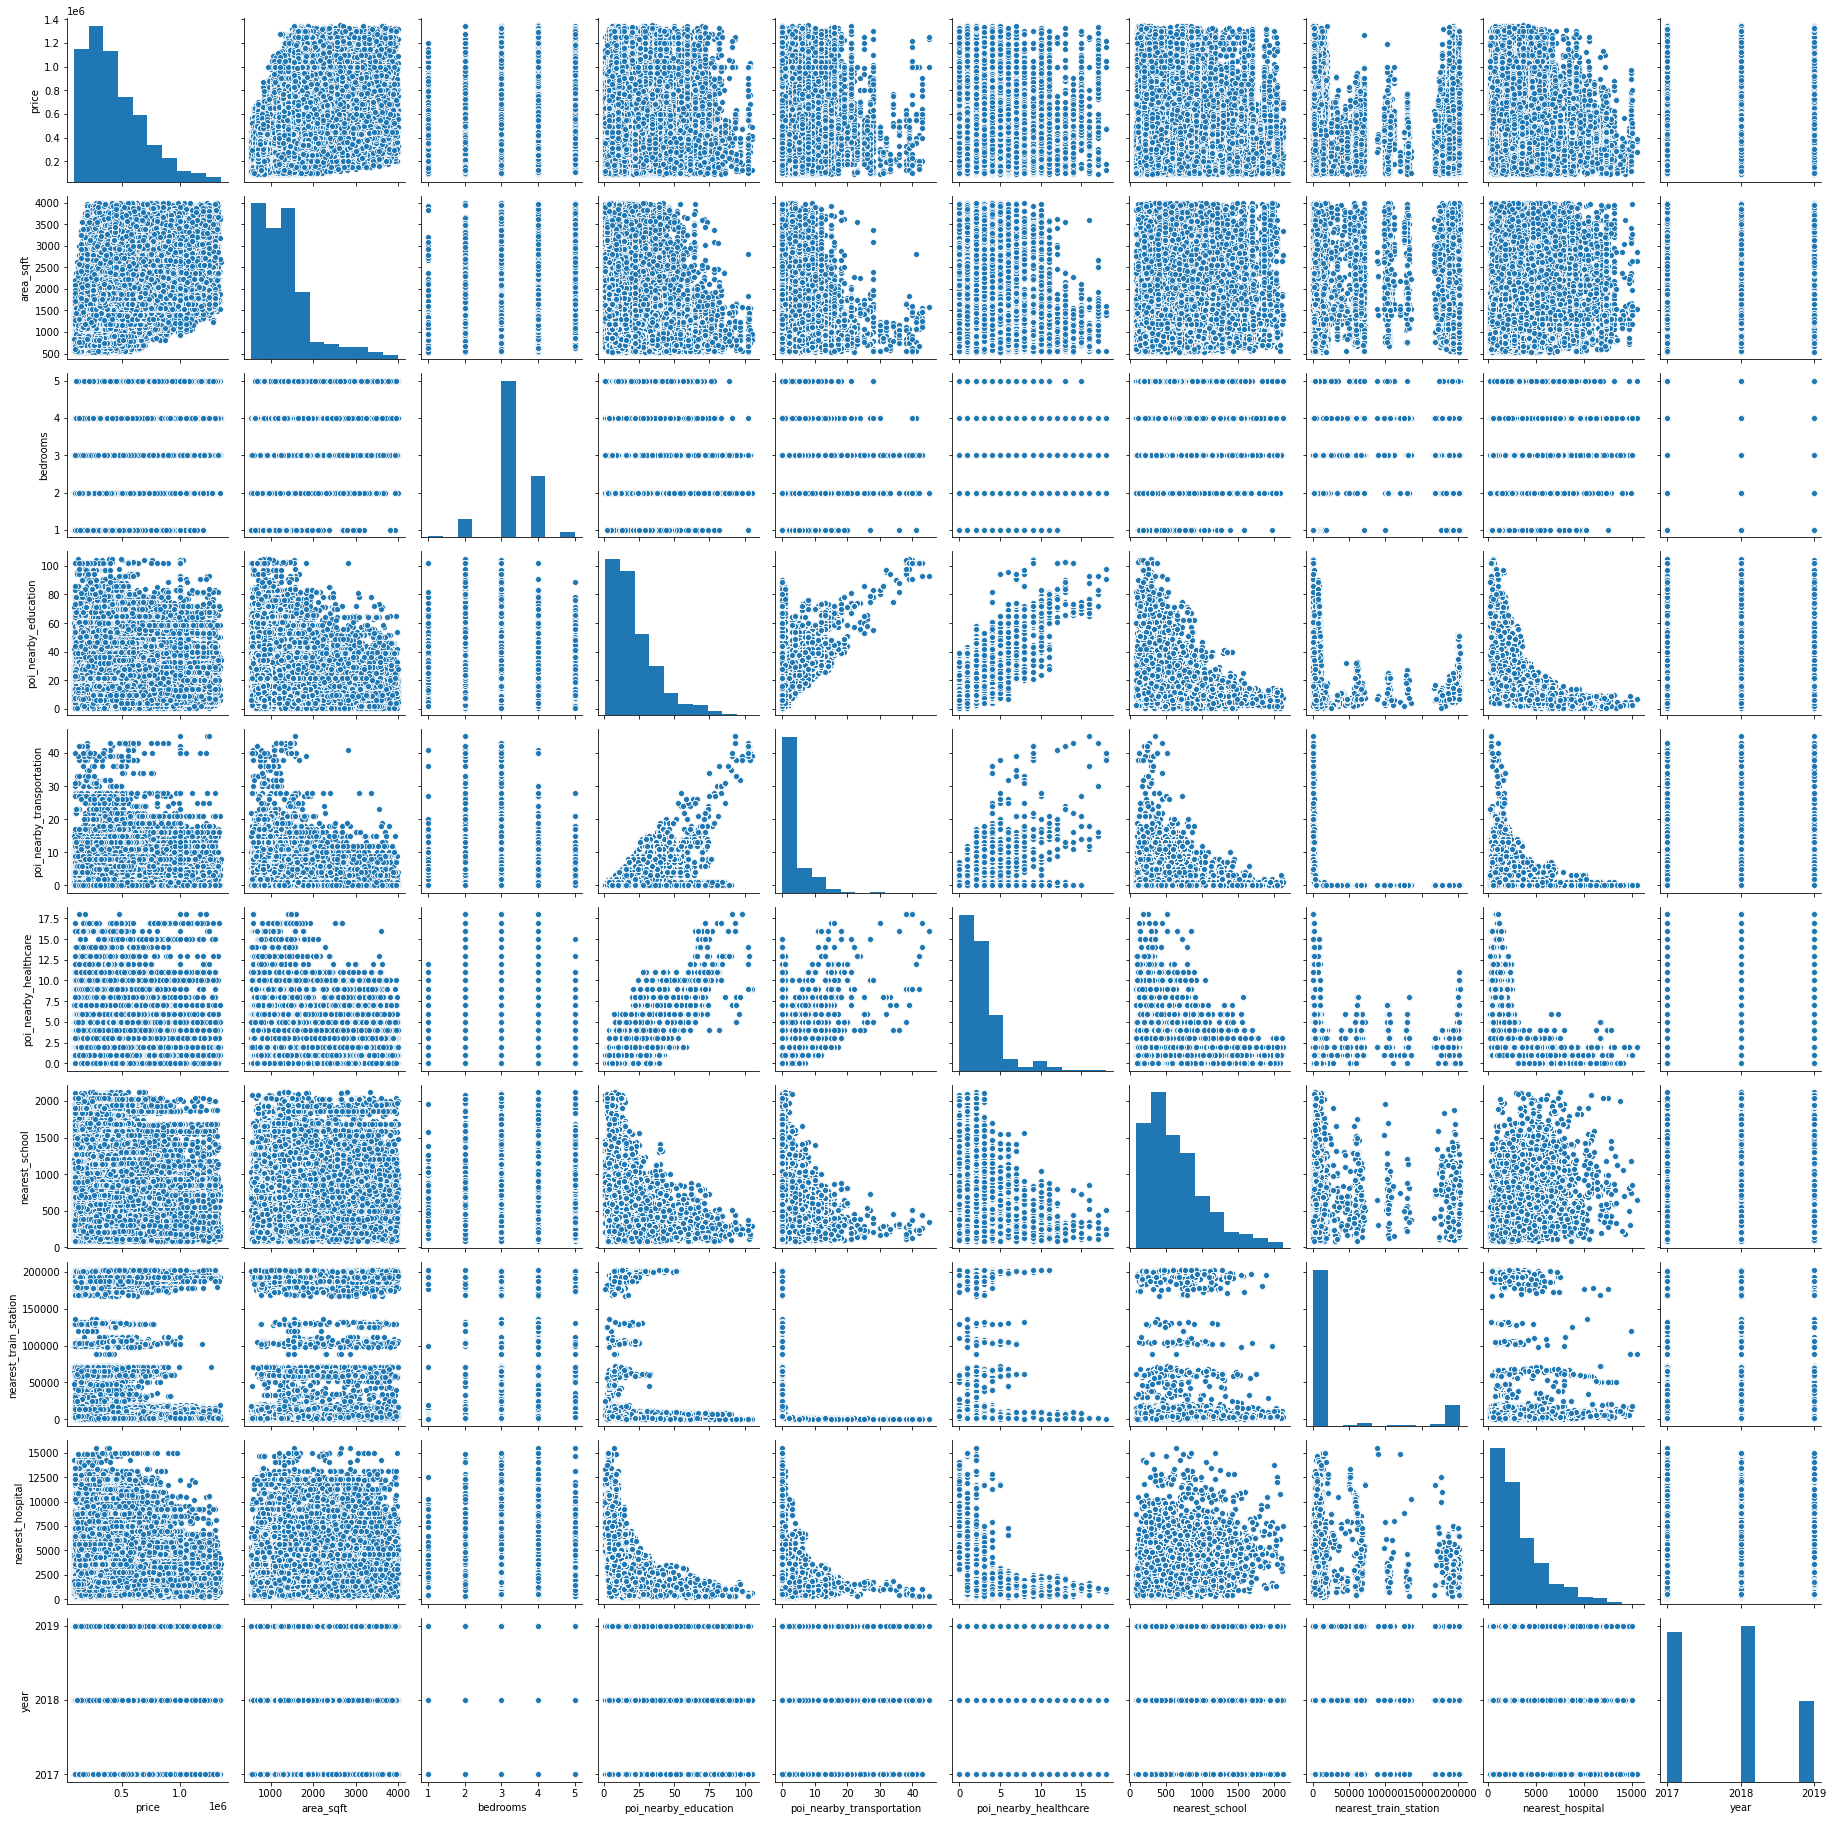

In [28]:
# sns.pairplot(transactions[['price', 'area_sqft', 'bedrooms', 'total_poi_nearby', 'nearest_poi']])
sns.pairplot(transactions[[
    'price', 'area_sqft', 'bedrooms', 'poi_nearby_education','poi_nearby_transportation','poi_nearby_healthcare', 
    'nearest_school', 'nearest_train_station', 'nearest_hospital', 'year'
]])

In [29]:
transactions.to_csv(transaction_csv)